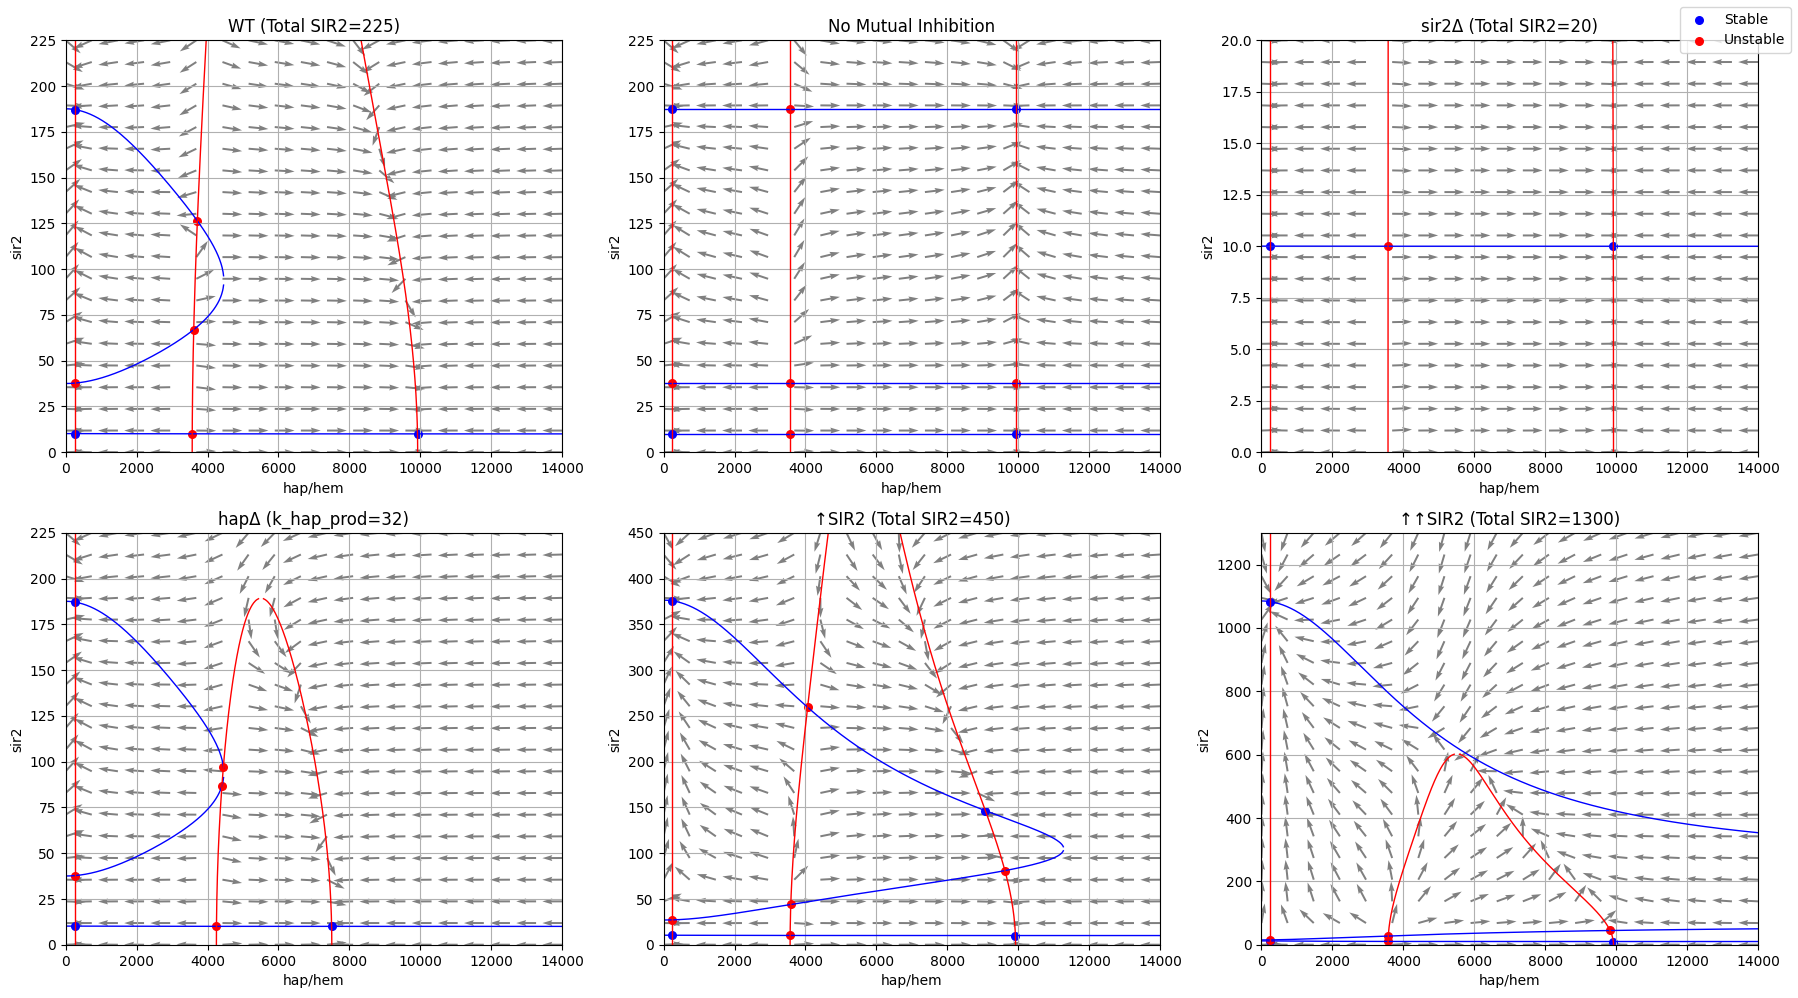

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_phase_plane(Total, k_hap_prod, neg_strength1, neg_strength2, ax, title):
    # Fixed parameters
    k_hap_deg = 0.004
    k_hap_prod_base = 1
    KM_SonH = 280
    KM_pos = 4250
    k_sir_prod = 0.02
    k_sir_deg = 0.004
    KM_HonS = 2200
    KM_pos2 = 90
    k_sir_prod_base = 0.04
    n1 = 4
    n3 = 4
    n4 = 2

    # --- Fine grid for accuracy ---
    h_vals = np.linspace(0, 14000, 1001)
    s_vals = np.linspace(0, Total, 401)

    # --- SIR2 nullcline (blue) ---
    s_nulls = []
    for h in h_vals:
        neg_fac = (neg_strength1 * h**n4 + KM_HonS**n4) / (h**n4 + KM_HonS**n4)
        coeffs = [
            -k_sir_deg - k_sir_prod * neg_fac,
            k_sir_prod * neg_fac * Total + k_sir_prod_base,
            0, 0,
            -k_sir_deg * KM_pos2**4,
            k_sir_prod_base * KM_pos2**4
        ]
        roots = np.roots(coeffs)
        real_roots = np.sort(roots[np.isreal(roots)].real)
        # Only keep roots in the physical range [0, Total]
        real_roots = real_roots[(real_roots >= 0) & (real_roots <= Total)]
        s_nulls.append(real_roots if real_roots.size > 0 else [np.nan])
    max_len = max(len(r) for r in s_nulls)
    s_line = np.full((len(h_vals), max_len), np.nan)
    for i, r in enumerate(s_nulls):
        s_line[i, :len(r)] = r

    # --- HAP nullcline (red) ---
    h_nulls = []
    for s in s_vals:
        neg_fac2 = (neg_strength2 * s**n4 + KM_SonH**n4) / (s**n4 + KM_SonH**n4)
        coeffs = [
            -k_hap_deg,
            k_hap_prod_base + k_hap_prod * neg_fac2,
            0, 0,
            -k_hap_deg * KM_pos**4,
            k_hap_prod_base * KM_pos**4
        ]
        roots = np.roots(coeffs)
        real_roots = np.sort(roots[np.isreal(roots)].real)
        # Only keep roots in the physical range [0, 14000]
        real_roots = real_roots[(real_roots >= 0) & (real_roots <= 14000)]
        h_nulls.append(real_roots if real_roots.size > 0 else [np.nan])
    max_len_h = max(len(r) for r in h_nulls)
    h_line = np.full((len(s_vals), max_len_h), np.nan)
    for i, r in enumerate(h_nulls):
        h_line[i, :len(r)] = r

    # --- Vector field for quiver plot ---
    h_2 = np.linspace(0, 14000, 20)
    s_2 = np.linspace(0, Total, 20)
    X, Y = np.meshgrid(h_2, s_2)
    neg_fac1 = (neg_strength1 * X**n4 + KM_HonS**n4) / (X**n4 + KM_HonS**n4)
    ds = k_sir_prod * neg_fac1 * (Y**n3 / (Y**n3 + KM_pos2**n3)) * (Total - Y) + k_sir_prod_base - k_sir_deg * Y
    neg_fac2 = (neg_strength2 * Y**n4 + KM_SonH**n4) / (Y**n4 + KM_SonH**n4)
    dh = k_hap_prod * neg_fac2 * (X**n3 / (X**n3 + KM_pos**n3)) + k_hap_prod_base - k_hap_deg * X
    magnitude = np.sqrt(dh**2 + ds**2)
    dh_norm = dh / (magnitude + 1e-10)
    ds_norm = ds / (magnitude + 1e-10)

    # --- Find true intersections using sign change and interpolation ---
    fixed_points = []
    for branch in range(h_line.shape[1]):
        h_nc = h_line[:, branch]
        mask = ~np.isnan(h_nc)
        if np.sum(mask) < 2:
            continue
        h_nc = h_nc[mask]
        s_nc = s_vals[mask]
        for sbranch in range(s_line.shape[1]):
            s_sir = s_line[:, sbranch]
            mask2 = ~np.isnan(s_sir)
            if np.sum(mask2) < 2:
                continue
            h_sir = h_vals[mask2]
            s_sir = s_sir[mask2]
            try:
                s_sir_func = interp1d(h_sir, s_sir, bounds_error=False, fill_value=np.nan)
            except Exception:
                continue
            diff = s_sir_func(h_nc) - s_nc
            sign_change = np.where(np.diff(np.sign(diff)) != 0)[0]
            for idx in sign_change:
                # Linear interpolation for intersection
                h_fp = h_nc[idx] + (h_nc[idx+1] - h_nc[idx]) * abs(diff[idx]) / (abs(diff[idx]) + abs(diff[idx+1]))
                s_fp = s_nc[idx] + (s_nc[idx+1] - s_nc[idx]) * abs(diff[idx]) / (abs(diff[idx]) + abs(diff[idx+1]))
                fixed_points.append((h_fp, s_fp))

    # Remove duplicates (close points)
    fixed_points = np.array(fixed_points)
    if len(fixed_points) > 0:
        unique_fp = []
        for pt in fixed_points:
            if not any(np.linalg.norm(pt - np.array(other)) < 1 for other in unique_fp):
                unique_fp.append(pt)
        fixed_points = np.array(unique_fp)
    else:
        fixed_points = np.empty((0, 2))

    # --- Jacobian & stability analysis ---
    def compute_jacobian(h, s):
        h_safe = max(h, 1e-6)
        s_safe = max(s, 1e-6)
        d_neg1_dh = (
            neg_strength1 * n4 * h_safe**(n4 - 1) * KM_HonS**n4
            - neg_strength1 * n4 * h_safe**(2 * n4 - 1)
        ) / (h_safe**n4 + KM_HonS**n4)**2
        d_neg2_ds = (
            neg_strength2 * n4 * s_safe**(n4 - 1) * KM_SonH**n4
            - neg_strength2 * n4 * s_safe**(2 * n4 - 1)
        ) / (s_safe**n4 + KM_SonH**n4)**2
        neg_fac1 = (neg_strength1 * h_safe**n4 + KM_HonS**n4) / (h_safe**n4 + KM_HonS**n4)
        neg_fac2 = (neg_strength2 * s_safe**n4 + KM_SonH**n4) / (s_safe**n4 + KM_SonH**n4)
        dF1_dh = (
            k_hap_prod * neg_fac2 *
            (n3 * h_safe**(n3 - 1) * KM_pos**n3) / (h_safe**n3 + KM_pos**n3)**2
            - k_hap_deg
        )
        dF1_ds = (
            k_hap_prod * d_neg2_ds * (h_safe**n3 / (h_safe**n3 + KM_pos**n3))
        )
        dF2_dh = (
            k_sir_prod * d_neg1_dh * (s_safe**n3 / (s_safe**n3 + KM_pos2**n3)) * (Total - s_safe)
        )
        dF2_ds = (
            k_sir_prod * neg_fac1 *
            ((n3 * s_safe**(n3 - 1) * KM_pos2**n3 * (Total - s_safe) - (s_safe**n3 / (s_safe**n3 + KM_pos2**n3)) )) / (s_safe**n3 + KM_pos2**n3)**2
            - k_sir_prod * neg_fac1 * (s_safe**n3 / (s_safe**n3 + KM_pos2**n3))
            - k_sir_deg
        )
        return np.array([[dF1_dh, dF1_ds], [dF2_dh, dF2_ds]])

    stable_pts = []
    unstable_pts = []
    for h_fp, s_fp in fixed_points:
        J = compute_jacobian(h_fp, s_fp)
        if not np.all(np.isfinite(J)):
            continue
        eigvals = np.linalg.eigvals(J)
        if np.all(np.real(eigvals) < 0):
            stable_pts.append((h_fp, s_fp))
        else:
            unstable_pts.append((h_fp, s_fp))

    # --- Plot ---
    for i in range(s_line.shape[1]):
        ax.plot(h_vals, s_line[:, i], 'b', linewidth=1)
    for i in range(h_line.shape[1]):
        ax.plot(h_line[:, i], s_vals, 'r', linewidth=1)
    ax.quiver(X, Y, dh_norm, ds_norm, color='gray', scale=25, width=0.004)
    if stable_pts:
        stable_pts = np.array(stable_pts)
        ax.scatter(stable_pts[:, 0], stable_pts[:, 1], c='blue', s=30, label='Stable')
    if unstable_pts:
        unstable_pts = np.array(unstable_pts)
        ax.scatter(unstable_pts[:, 0], unstable_pts[:, 1], c='red', s=30, label='Unstable')
    ax.set_xlabel('hap/hem')
    ax.set_ylabel('sir2')
    ax.set_ylim([0, Total])
    ax.set_xlim([0, 14000])
    ax.set_title(title)
    ax.grid(True)

# --- Subplots for different parameter sets ---
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

plot_phase_plane(Total=225, k_hap_prod=40, neg_strength1=0.05, neg_strength2=0.65, ax=axs[0,0], title='WT (Total SIR2=225)')
plot_phase_plane(Total=225, k_hap_prod=40, neg_strength1=1, neg_strength2=1, ax=axs[0,1], title='No Mutual Inhibition')
plot_phase_plane(Total=20, k_hap_prod=40, neg_strength1=0.05, neg_strength2=0.65, ax=axs[0,2], title='sir2Δ (Total SIR2=20)')
plot_phase_plane(Total=225, k_hap_prod=32, neg_strength1=0.05, neg_strength2=0.65, ax=axs[1,0], title='hapΔ (k_hap_prod=32)')
plot_phase_plane(Total=450, k_hap_prod=40, neg_strength1=0.05, neg_strength2=0.65, ax=axs[1,1], title='↑SIR2 (Total SIR2=450)')
plot_phase_plane(Total=1300, k_hap_prod=40, neg_strength1=0.05, neg_strength2=0.65, ax=axs[1,2], title='↑↑SIR2 (Total SIR2=1300)')

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()



### 🧠 **Simplified Notes: Heme, HAP, and Mode 2 Aging in Yeast**

#### 🔹 What is Mode 2 Aging?

* One of two aging paths in yeast cells.
* **Characterized by mitochondrial damage**, low respiration, and genomic instability.

#### 🔹 Role of **Heme**:

* A molecule made in mitochondria.
* Signals how healthy mitochondria are.
* **Less heme = mitochondria are damaged.**

#### 🔹 Role of **HAP Complex**:

* A group of proteins that turn on genes needed for mitochondrial function.
* Needs heme to work properly.
* **Less heme → weak HAP activity → mitochondria get worse.**

#### 🔁 **Feedback Loop in Mode 2 Aging**:

```
Mitochondrial damage → ↓ Heme → ↓ HAP activity → ↓ Mitochondrial genes → More damage
```

#### 🔚 End Result:

* Cells stuck in a cycle of **low heme, weak mitochondria, and rapid aging**.
* This is how cells enter and stay in **mode 2 aging**.

